# Calculate Customer Lifetime Value

This analysis is based on cohort-level.

**Dataset Information:**

The csv file has paying member historical data arranged by Policy_number from January 2015 to December 2019.

**Attribute Information:**
-	Start Date, Start Month and Churn Date of the policy
-	Number of members per policy 
-	Maximum duration that the plan allows 
-	State of the policy holder
-	Insurance carrier or provider of the policy 

# Data loading

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import math
# continuous target evaluation
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
# print out common metrics to evaluate regression models
def evaluation(y_true, y_predicted):
    print('root mean square error: ',np.round(np.sqrt(mean_squared_error(y_true, y_predicted)),2))
    print('mean square error: ', np.round(mean_squared_error(y_true, y_predicted),2))
    print('explained_variance_score: ', np.round(explained_variance_score(y_true, y_predicted),2))
    print('max_error: ', np.round(max_error(y_true, y_predicted),2))
    print('mean_absolute_error: ', np.round(mean_absolute_error(y_true, y_predicted),2))
    print('median_absolute_error: ', np.round(median_absolute_error(y_true, y_predicted),2))

In [2]:
#Import Data
df=pd.read_csv("cohort.csv", encoding="cp1252")
df.head()

,POLICY_NUMBER,START_DATE,START_MONTH,CHURN_DATE,MEMBERS,MAX_DURATION,STATE,CARRIER_NAME
0,97662795,1-Apr-16,4,1-Oct-16,1,184,AZ,CARRIER2
1,100915150,1-Dec-16,12,1-Dec-16,1,180,OR,CARRIER1
2,99747655,1-Oct-16,10,1-Mar-17,1,180,NC,CARRIER3
3,99406855,1-Sep-16,9,1-Jan-17,1,180,AK,CARRIER3
4,102166525,1-Jan-17,1,1-Feb-17,2,184,AZ,CARRIER2


# Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303235 entries, 0 to 303234
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   POLICY_NUMBER  303235 non-null  int64 
 1   START_DATE     303235 non-null  object
 2   START_MONTH    303235 non-null  int64 
 3   CHURN_DATE     303235 non-null  object
 4   MEMBERS        303235 non-null  int64 
 5   MAX_DURATION   303235 non-null  int64 
 6   STATE          303235 non-null  object
 7   CARRIER_NAME   303235 non-null  object
dtypes: int64(4), object(4)
memory usage: 18.5+ MB


In [4]:
#Check the shape (number of columns and rows) in the dataset
df.shape

(303235, 8)

In [5]:
#Find out missing values
df.isnull().sum(axis=0)

POLICY_NUMBER    0
START_DATE       0
START_MONTH      0
CHURN_DATE       0
MEMBERS          0
MAX_DURATION     0
STATE            0
CARRIER_NAME     0
dtype: int64

In [6]:
df['lifespan']=(pd.to_datetime(df['CHURN_DATE'])-pd.to_datetime(df['START_DATE'])).apply(lambda x: x.days)+1

In [7]:
#change data type to Quarter
df['START_DATE_q'] = pd.to_datetime(df['START_DATE']).dt.to_period('Q')
df['CHURN_DATE_q'] = pd.to_datetime(df['CHURN_DATE']).dt.to_period('Q')

In [8]:
#change data type to Month
df['START_DATE'] = pd.to_datetime(df['START_DATE']).dt.to_period('M')
df['CHURN_DATE'] = pd.to_datetime(df['CHURN_DATE']).dt.to_period('M')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303235 entries, 0 to 303234
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype        
---  ------         --------------   -----        
 0   POLICY_NUMBER  303235 non-null  int64        
 1   START_DATE     303235 non-null  period[M]    
 2   START_MONTH    303235 non-null  int64        
 3   CHURN_DATE     303235 non-null  period[M]    
 4   MEMBERS        303235 non-null  int64        
 5   MAX_DURATION   303235 non-null  int64        
 6   STATE          303235 non-null  object       
 7   CARRIER_NAME   303235 non-null  object       
 8   lifespan       303235 non-null  int64        
 9   START_DATE_q   303235 non-null  period[Q-DEC]
 10  CHURN_DATE_q   303235 non-null  period[Q-DEC]
dtypes: int64(5), object(2), period[M](2), period[Q-DEC](2)
memory usage: 25.4+ MB


In [10]:
#change columns
df.columns=[i.lower() for i in df.columns]

In [11]:
df.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q
0,97662795,2016-04,4,2016-10,1,184,AZ,CARRIER2,184,2016Q2,2016Q4
1,100915150,2016-12,12,2016-12,1,180,OR,CARRIER1,1,2016Q4,2016Q4
2,99747655,2016-10,10,2017-03,1,180,NC,CARRIER3,152,2016Q4,2017Q1
3,99406855,2016-09,9,2017-01,1,180,AK,CARRIER3,123,2016Q3,2017Q1
4,102166525,2017-01,1,2017-02,2,184,AZ,CARRIER2,32,2017Q1,2017Q1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303235 entries, 0 to 303234
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype        
---  ------         --------------   -----        
 0   policy_number  303235 non-null  int64        
 1   start_date     303235 non-null  period[M]    
 2   start_month    303235 non-null  int64        
 3   churn_date     303235 non-null  period[M]    
 4   members        303235 non-null  int64        
 5   max_duration   303235 non-null  int64        
 6   state          303235 non-null  object       
 7   carrier_name   303235 non-null  object       
 8   lifespan       303235 non-null  int64        
 9   start_date_q   303235 non-null  period[Q-DEC]
 10  churn_date_q   303235 non-null  period[Q-DEC]
dtypes: int64(5), object(2), period[M](2), period[Q-DEC](2)
memory usage: 25.4+ MB


In [13]:
# #change data type
# df['start_month'] = df['start_month'].astype(object)
# df['members'] = df['start_month'].astype(object)
# df['max_duration'] = df['max_duration'].astype(object)
# df['start_month'] = df['start_month'].astype(object)

In [14]:
df=df.sort_values(by=['start_date', 'churn_date'])

In [15]:
df=df.sort_values(by='start_date')
df.head()
from operator import attrgetter
df['duration_mon']=(df['churn_date']-df['start_date']).apply(attrgetter('n'))
#remove data that start date 
print(df[df['duration_mon']<0].shape[0]/df.shape[0])
print('Invaild data is 1.06% of the total data, so we can remove them' )
df=df[df['duration_mon']>=0]

0.018685178162151466
Invaild data is 1.06% of the total data, so we can remove them


In [16]:
df.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q,duration_mon
109387,87161260,2015-01,1,2015-03,1,180,AL,CARRIER1,60,2015Q1,2015Q1,2
109035,86100230,2015-01,1,2015-03,1,180,UT,CARRIER1,60,2015Q1,2015Q1,2
108472,86722815,2015-01,1,2015-03,3,180,NC,CARRIER2,60,2015Q1,2015Q1,2
108002,86833380,2015-01,1,2015-03,2,360,TX,CARRIER2,60,2015Q1,2015Q1,2
107726,86091180,2015-01,1,2015-03,1,180,CO,CARRIER1,60,2015Q1,2015Q1,2


In [17]:
cols=['start_date', 'start_month', 'churn_date', 'members', 'max_duration', 'carrier_name', 'lifespan']

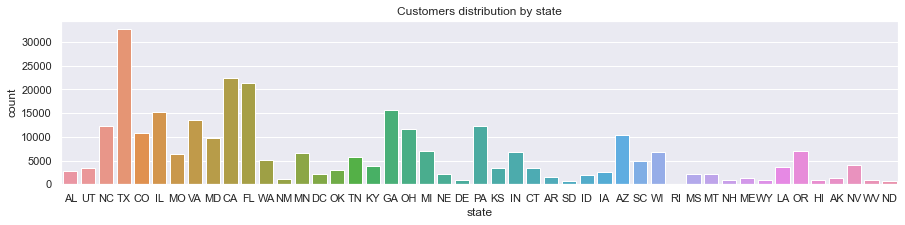

In [18]:
# Create plot
sns.set(font_scale=1,rc={'figure.figsize':(18, 4)})

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,3))
plt.title('Customers distribution by state')
g=sns.countplot(df['state'])
# g.set(xticks=[2, 5,10])

[[<matplotlib.axis.XTick at 0x11964d5d9d0>,

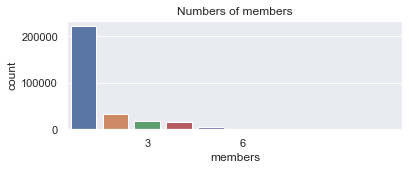

In [19]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,2))
plt.title('Numbers of members')
g=sns.countplot(df['members'])
g.set(xticks=[2, 5,10])

In [20]:
df=df.sort_values(by='carrier_name')

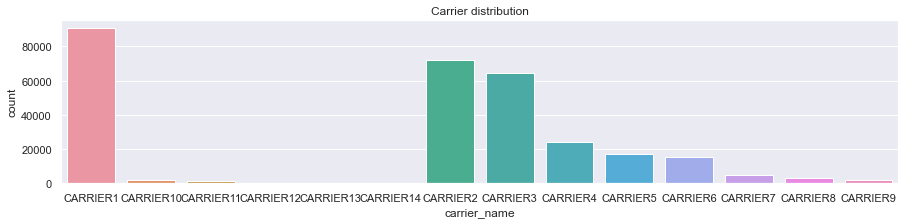

In [21]:
# Create plot
sns.set(font_scale=1,rc={'figure.figsize':(18, 4)})

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,3))
plt.title('Carrier distribution')
g=sns.countplot(df['carrier_name'].sort_values())
# g.set(xticks=[0,3,6,9,12])

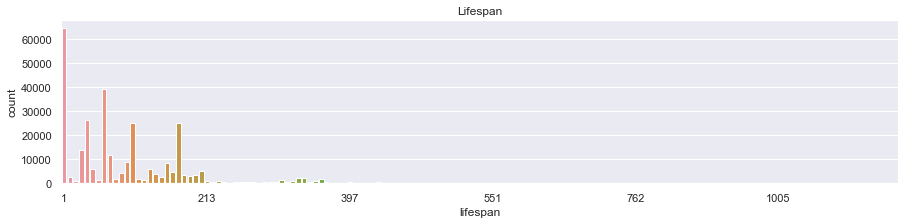

In [22]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,3))
plt.title('Lifespan')
g=sns.countplot(df['lifespan'].sort_values())
g.set(xticks=[0,25,50,75,100,125,146])
plt.show()

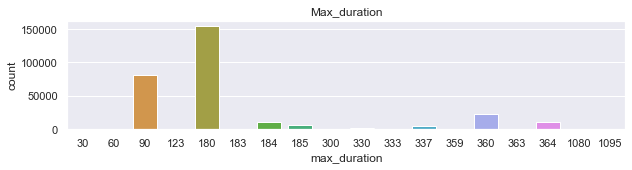

In [23]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,2))
plt.title('Max_duration')
g=sns.countplot(df['max_duration'])
# g.set(xticks=[0,3,6,9,12])

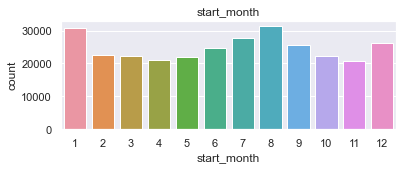

In [24]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,2))
plt.title('start_month')
g=sns.countplot(df['start_month'])
# g.set(xticks=[0,3,6,9,12])

In [25]:
df.describe()

,policy_number,start_month,members,max_duration,lifespan,duration_mon
count,2.975690e+05,297569.000000,297569.000000,297569.000000,297569.000000,297569.000000
mean,1.018391e+08,6.473534,1.495021,182.769788,90.330310,2.932382
std,8.572823e+06,3.466019,1.014617,95.494131,96.955889,3.183567
min,2.791784e+07,1.000000,1.000000,30.000000,1.000000,0.000000
25%,9.453583e+07,3.000000,1.000000,90.000000,31.000000,1.000000
50%,1.024964e+08,7.000000,1.000000,180.000000,62.000000,2.000000
75%,1.089867e+08,9.000000,2.000000,180.000000,152.000000,5.000000
max,1.210835e+08,12.000000,10.000000,1095.000000,1707.000000,56.000000


In [26]:
df.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q,duration_mon
109387,87161260,2015-01,1,2015-03,1,180,AL,CARRIER1,60,2015Q1,2015Q1,2
118371,96813775,2016-02,2,2016-07,1,180,TX,CARRIER1,152,2016Q1,2016Q3,5
118849,96629770,2016-02,2,2016-07,1,180,LA,CARRIER1,152,2016Q1,2016Q3,5
119051,96649545,2016-02,2,2016-07,1,180,KS,CARRIER1,152,2016Q1,2016Q3,5
119276,96632015,2016-02,2,2016-07,1,180,CA,CARRIER1,152,2016Q1,2016Q3,5


# Cohort Analysis


### 1. Based on year

In [27]:
df['duration_year']=df['churn_date'].dt.year-df['start_date'].dt.year+1
df['cohort_year']=df['start_date'].dt.year
#remove data that start date 
print(df[df['duration_year']<0].shape[0]/df.shape[0])
print('Invaild data is 0.39% of the total data, so we can remove them' )
df=df[df['duration_year']>=0]

0.0
Invaild data is 0.39% of the total data, so we can remove them


In [28]:
cohorts = df.groupby(['cohort_year','duration_year']).nunique()
cohorts = cohorts.policy_number.to_frame().reset_index()
cohorts = pd.pivot_table(cohorts, values = 'policy_number',index = 'cohort_year', columns= 'duration_year')
cohorts

duration_year,1,2,3,4,5,6
cohort_year,,,,,,
2015,61567.0,16229.0,62.0,5.0,1.0,5.0
2016,51915.0,12098.0,28.0,9.0,12.0,NaN
2017,43930.0,7129.0,535.0,290.0,NaN,NaN
2018,47701.0,14631.0,1720.0,NaN,NaN,NaN
2019,26533.0,13169.0,NaN,NaN,NaN,NaN


In [29]:
cohorts['total']=df.groupby('cohort_year').size()

<AxesSubplot:xlabel='duration_year', ylabel='cohort_year'>

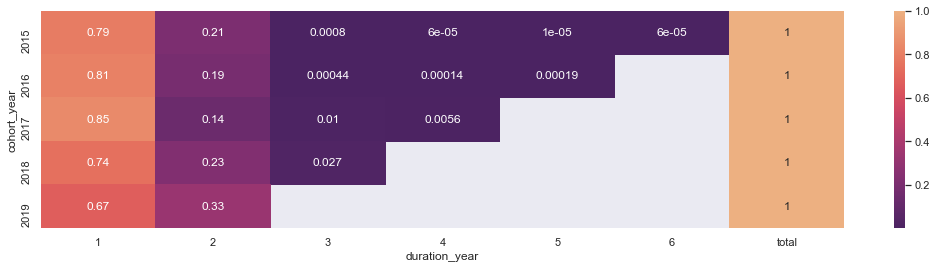

In [30]:
# Churn rate yearly Percentage
cohort_size=cohorts['total']
churn_year=round(cohorts.divide(cohort_size, axis=0),5)
#heatmap:
# plt.figure(figsize=(30,20))
sns.heatmap(data=churn_year,annot=True,
           cmap='flare_r')


In [31]:
#average retention rate:
average=pd.DataFrame(np.mean(churn_year, axis=0)).T
pd.concat([churn_year, average])


duration_year,1,2,3,4,5,6,total
2015,0.790650,0.208410,0.00080,0.00006,0.00001,0.00006,1.0
2016,0.810390,0.188850,0.00044,0.00014,0.00019,NaN,1.0
2017,0.846700,0.137400,0.01031,0.00559,NaN,NaN,1.0
2018,0.744720,0.228420,0.02685,NaN,NaN,NaN,1.0
2019,0.668300,0.331700,NaN,NaN,NaN,NaN,1.0
0,0.772152,0.218956,0.00960,0.00193,0.00010,0.00006,1.0


### 2. Based on Quarter

In [32]:
# based on quarter and create pivot table:
from operator import attrgetter
df['duration_q']=(df['churn_date_q']-df['start_date_q']).apply(attrgetter('n'))

In [33]:
#remove data that start date 
print(df[df['duration_q']<0].shape[0]/df.shape[0])
print('Invaild data is 0.42% of the total data, so we can remove them' )
df=df[df['duration_q']>=0]

0.0
Invaild data is 0.42% of the total data, so we can remove them


<AxesSubplot:xlabel='start_date_q', ylabel='count'>

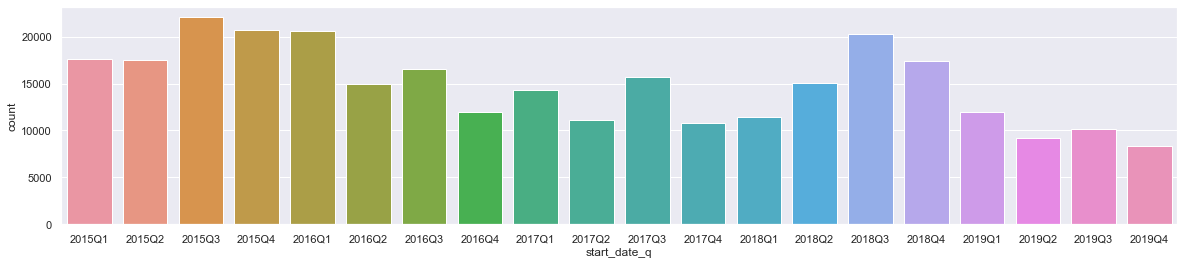

In [34]:
df=df.sort_values(by='start_date_q')
ax, fig=plt.subplots(figsize=(20,4))
sns.countplot(df['start_date_q'])

In [35]:
cohorts_q = df.groupby(['start_date_q','duration_q']).nunique()
cohorts_q = cohorts_q.policy_number.to_frame().reset_index()
cohorts_q.tail()

,start_date_q,duration_q,policy_number
174,2019Q3,0,2308
175,2019Q3,1,4124
176,2019Q3,2,3734
177,2019Q4,0,1759
178,2019Q4,1,6621


In [36]:
cohorts_q = pd.pivot_table(cohorts_q, values = 'policy_number',index = 'start_date_q', columns= 'duration_q')
cohorts_q['total']=df.groupby('start_date_q').size()

<AxesSubplot:xlabel='duration_q', ylabel='start_date_q'>

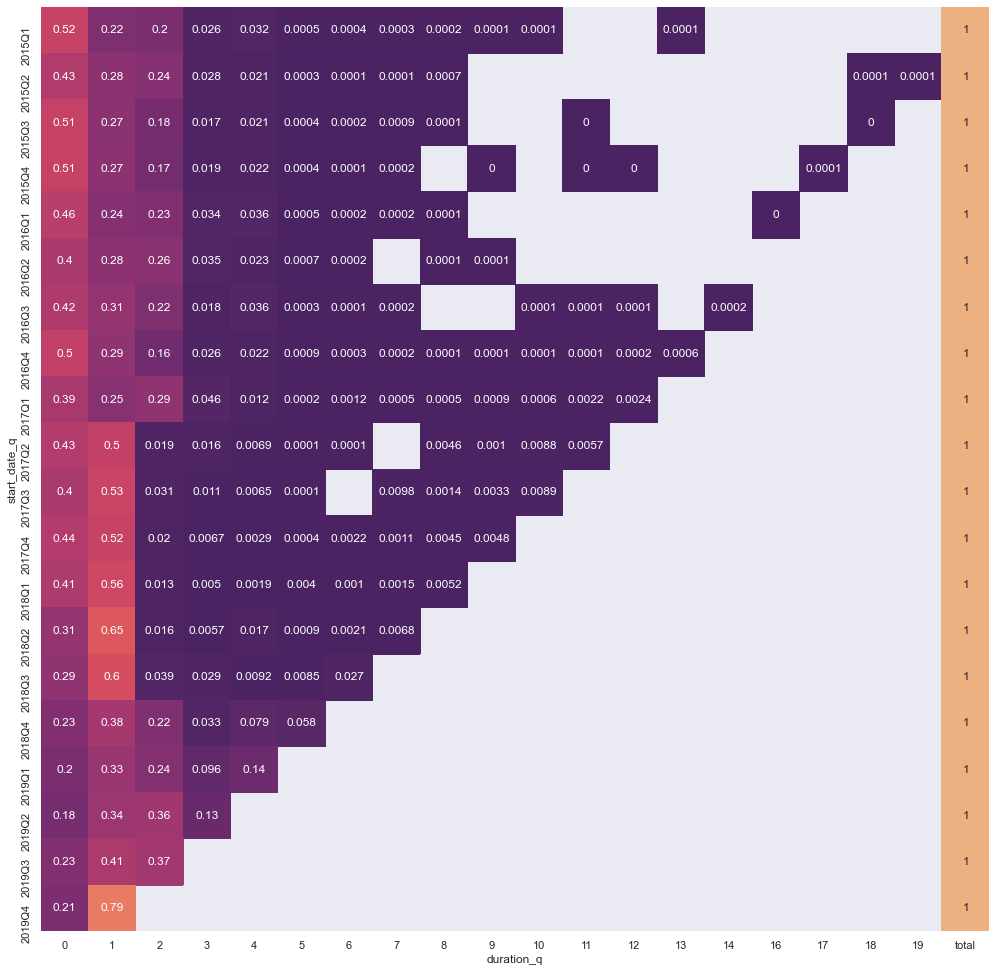

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,17))
#Percentage
cohort_size=cohorts_q['total']
churn_quarter=round(cohorts_q.divide(cohort_size, axis=0),4)
sns.heatmap(data=churn_quarter,annot=True,
           cmap='flare_r',cbar=False)

In [38]:
#average retention rate:
average=pd.DataFrame(np.mean(churn_quarter, axis=0)).T
pd.concat([churn_quarter, average])

duration_q,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,total
2015Q1,0.51770,0.21910,0.203100,0.026300,0.032200,0.00050,0.000400,0.000300,0.000200,0.000100,0.0001,NaN,NaN,0.00010,NaN,NaN,NaN,NaN,NaN,1.0
2015Q2,0.43000,0.27660,0.243000,0.027900,0.021100,0.00030,0.000100,0.000100,0.000700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00010,0.0001,1.0
2015Q3,0.51210,0.27150,0.176500,0.017100,0.021000,0.00040,0.000200,0.000900,0.000100,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,1.0
2015Q4,0.51390,0.27370,0.169800,0.019200,0.022300,0.00040,0.000100,0.000200,NaN,0.000000,NaN,0.00000,0.000000,NaN,NaN,NaN,0.0001,NaN,NaN,1.0
2016Q1,0.46070,0.24010,0.228800,0.033700,0.035700,0.00050,0.000200,0.000200,0.000100,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
2016Q2,0.40120,0.27680,0.262900,0.035100,0.023000,0.00070,0.000200,NaN,0.000100,0.000100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2016Q3,0.41930,0.30930,0.216400,0.018300,0.035600,0.00030,0.000100,0.000200,NaN,NaN,0.0001,0.00010,0.000100,NaN,0.0002,NaN,NaN,NaN,NaN,1.0
2016Q4,0.49850,0.29140,0.159500,0.026000,0.022200,0.00090,0.000300,0.000200,0.000100,0.000100,0.0001,0.00010,0.000200,0.00060,NaN,NaN,NaN,NaN,NaN,1.0
2017Q1,0.39200,0.25400,0.287200,0.046200,0.012200,0.00020,0.001200,0.000500,0.000500,0.000900,0.0006,0.00220,0.002400,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2017Q2,0.43390,0.50400,0.019200,0.015800,0.006900,0.00010,0.000100,NaN,0.004600,0.001000,0.0088,0.00570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 3. Based on month

In [79]:
from operator import attrgetter
df['duration_mon']=(df['churn_date']-df['start_date']).apply(attrgetter('n'))
#remove data that start date 
print(df[df['duration_mon']<0].shape[0]/df.shape[0])
df=df[df['duration_mon']>=0]

0.0


In [80]:
df=df.sort_values(by=['start_date','churn_date'])

In [81]:
cohorts = df.groupby(['start_date','duration_mon']).nunique()
cohorts = cohorts.policy_number.to_frame().reset_index()
cohorts = pd.pivot_table(cohorts, values = 'policy_number',index = 'start_date', columns= 'duration_mon')
cohorts.head()

duration_mon,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,48,50,51,53,56
start_date,,,,,,,,,,,,,,,,,,,,,
2015-01,3002.0,1127.0,627.0,295.0,195.0,952.0,184.0,24.0,25.0,16.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,1755.0,1040.0,462.0,319.0,235.0,1323.0,184.0,37.0,26.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,1586.0,747.0,370.0,292.0,272.0,1154.0,382.0,22.0,24.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,1601.0,771.0,413.0,365.0,256.0,1411.0,288.0,36.0,48.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05,1794.0,856.0,421.0,312.0,257.0,1455.0,253.0,67.0,41.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
a=np.sum(cohorts, axis=1)
cohorts['total']=a
cols=cohorts.columns

In [83]:
cohorts.head()

duration_mon,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,48,50,51,53,56,total
start_date,,,,,,,,,,,,,,,,,,,,,
2015-01,3002.0,1127.0,627.0,295.0,195.0,952.0,184.0,24.0,25.0,16.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6723.0
2015-02,1755.0,1040.0,462.0,319.0,235.0,1323.0,184.0,37.0,26.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5702.0
2015-03,1586.0,747.0,370.0,292.0,272.0,1154.0,382.0,22.0,24.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5224.0
2015-04,1601.0,771.0,413.0,365.0,256.0,1411.0,288.0,36.0,48.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5462.0
2015-05,1794.0,856.0,421.0,312.0,257.0,1455.0,253.0,67.0,41.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5677.0


In [84]:
cohorts=cohorts.fillna(0)

In [85]:
cohorts_retention=pd.DataFrame()
inter=cohorts['total']
for i in range(len(cols)-1):
    inter = inter - cohorts[cols[i]]
    cohorts_retention[str(cols[i])+' month']=inter

In [86]:
cohorts_retention['total']=a

In [87]:
cohorts_retention.head()

,0 month,1 month,2 month,3 month,4 month,5 month,6 month,7 month,8 month,9 month,...,39 month,40 month,41 month,42 month,48 month,50 month,51 month,53 month,56 month,total
start_date,,,,,,,,,,,,,,,,,,,,,
2015-01,3721.0,2594.0,1967.0,1672.0,1477.0,525.0,341.0,317.0,292.0,276.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6723.0
2015-02,3947.0,2907.0,2445.0,2126.0,1891.0,568.0,384.0,347.0,321.0,302.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5702.0
2015-03,3638.0,2891.0,2521.0,2229.0,1957.0,803.0,421.0,399.0,375.0,323.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5224.0
2015-04,3861.0,3090.0,2677.0,2312.0,2056.0,645.0,357.0,321.0,273.0,238.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5462.0
2015-05,3883.0,3027.0,2606.0,2294.0,2037.0,582.0,329.0,262.0,221.0,189.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5677.0


,1 month,2 month,3 month,4 month,5 month,6 month,7 month,8 month,9 month,10 month,...,39 month,40 month,41 month,42 month,48 month,50 month,51 month,53 month,56 month,total month
start_date,,,,,,,,,,,,,,,,,,,,,
2015-01,0.697124,0.758288,0.850025,0.883373,0.355450,0.649524,0.929619,0.921136,0.945205,0.865942,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,inf
2015-02,0.736509,0.841073,0.869530,0.889464,0.300370,0.676056,0.903646,0.925072,0.940810,0.738411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2015-03,0.794667,0.872017,0.884173,0.877972,0.410322,0.524284,0.947743,0.939850,0.861333,0.743034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2015-04,0.800311,0.866343,0.863653,0.889273,0.313716,0.553488,0.899160,0.850467,0.871795,0.777311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2015-05,0.779552,0.860918,0.880276,0.887969,0.285714,0.565292,0.796353,0.843511,0.855204,0.793651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


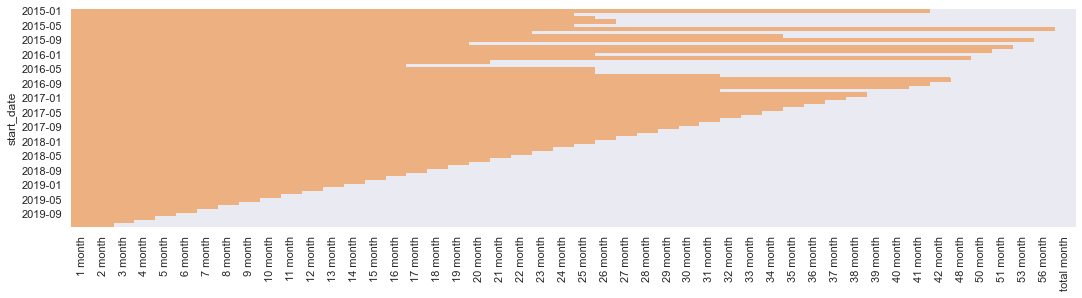

In [88]:
r=pd.DataFrame()
for i in range(len(cols)-1):
    r[str(cols[i+1])+' month']=cohorts_retention.iloc[:,i+1]/cohorts_retention.iloc[:,i]
#heatmap:
# plt.figure(figsize=(30,20))
sns.heatmap(data=r,
           cmap='flare',cbar=False)
r.head()

In [89]:
r=r.drop('total month', axis=1)

In [90]:
r=r.T

In [91]:
r.head()

start_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
1 month,0.697124,0.736509,0.794667,0.800311,0.779552,0.764581,0.769019,0.739509,0.774283,0.764548,...,0.873646,0.892041,0.883544,0.885839,0.867999,0.854025,0.856149,0.879022,0.866313,0.816901
2 month,0.758288,0.841073,0.872017,0.866343,0.860918,0.874193,0.842932,0.851445,0.849529,0.731692,...,0.834711,0.832155,0.831355,0.828169,0.841509,0.790401,0.790936,0.746525,0.753705,0.000000
3 month,0.850025,0.869530,0.884173,0.863653,0.880276,0.859606,0.882968,0.882113,0.737950,0.763549,...,0.785329,0.816348,0.795175,0.829932,0.842601,0.846221,0.742703,0.715705,0.000000,NaN
4 month,0.883373,0.889464,0.877972,0.889273,0.887969,0.883749,0.900037,0.771561,0.782271,0.838580,...,0.900860,0.890767,0.889783,0.885758,0.862693,0.798141,0.761281,0.000000,NaN,NaN
5 month,0.355450,0.300370,0.410322,0.313716,0.285714,0.432608,0.280132,0.314088,0.443340,0.364505,...,0.611959,0.754745,0.553932,0.669173,0.502159,0.489004,0.000000,NaN,NaN,NaN


In [92]:
r['r']=np.mean(r, axis=1)

In [93]:
r.head()

start_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,r
1 month,0.697124,0.736509,0.794667,0.800311,0.779552,0.764581,0.769019,0.739509,0.774283,0.764548,...,0.892041,0.883544,0.885839,0.867999,0.854025,0.856149,0.879022,0.866313,0.816901,0.811630
2 month,0.758288,0.841073,0.872017,0.866343,0.860918,0.874193,0.842932,0.851445,0.849529,0.731692,...,0.832155,0.831355,0.828169,0.841509,0.790401,0.790936,0.746525,0.753705,0.000000,0.691083
3 month,0.850025,0.869530,0.884173,0.863653,0.880276,0.859606,0.882968,0.882113,0.737950,0.763549,...,0.816348,0.795175,0.829932,0.842601,0.846221,0.742703,0.715705,0.000000,NaN,0.635702
4 month,0.883373,0.889464,0.877972,0.889273,0.887969,0.883749,0.900037,0.771561,0.782271,0.838580,...,0.890767,0.889783,0.885758,0.862693,0.798141,0.761281,0.000000,NaN,NaN,0.833802
5 month,0.355450,0.300370,0.410322,0.313716,0.285714,0.432608,0.280132,0.314088,0.443340,0.364505,...,0.754745,0.553932,0.669173,0.502159,0.489004,0.000000,NaN,NaN,NaN,0.565646


<AxesSubplot:title={'center':'Monthly Retention Rate'}>

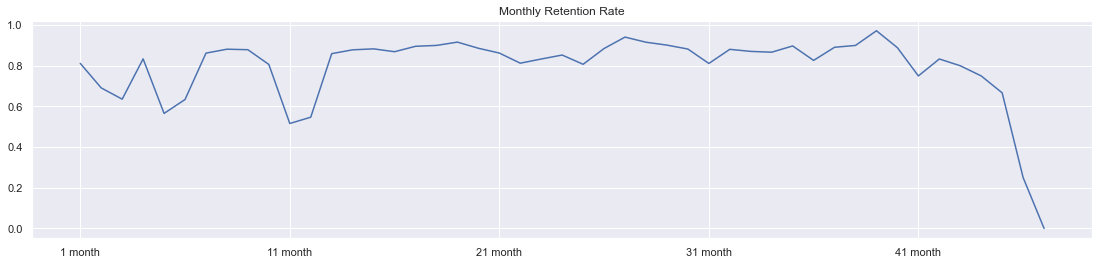

In [94]:
# r['retention_rate']=np.mean(r, axis=1)
fig, ax = plt.subplots(figsize=(19,4))
plt.title('Monthly Retention Rate')
r['r'].plot()

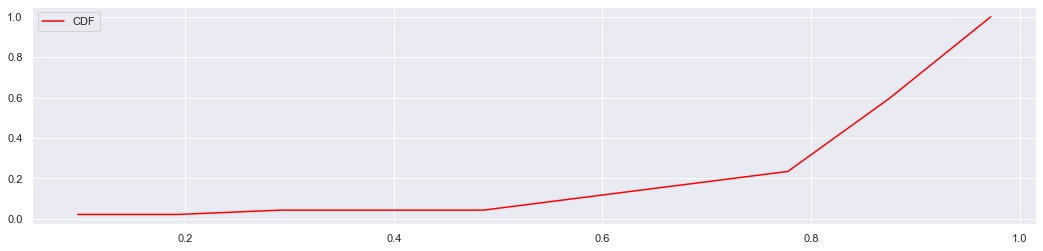

In [95]:
res=r['r'].dropna()
res=res.to_frame().reset_index(drop=True)
import matplotlib.pyplot as plt 
import numpy as np 
count, bins_count = np.histogram(res, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, color='red',label="CDF")
plt.legend()

## Second method for retention rate

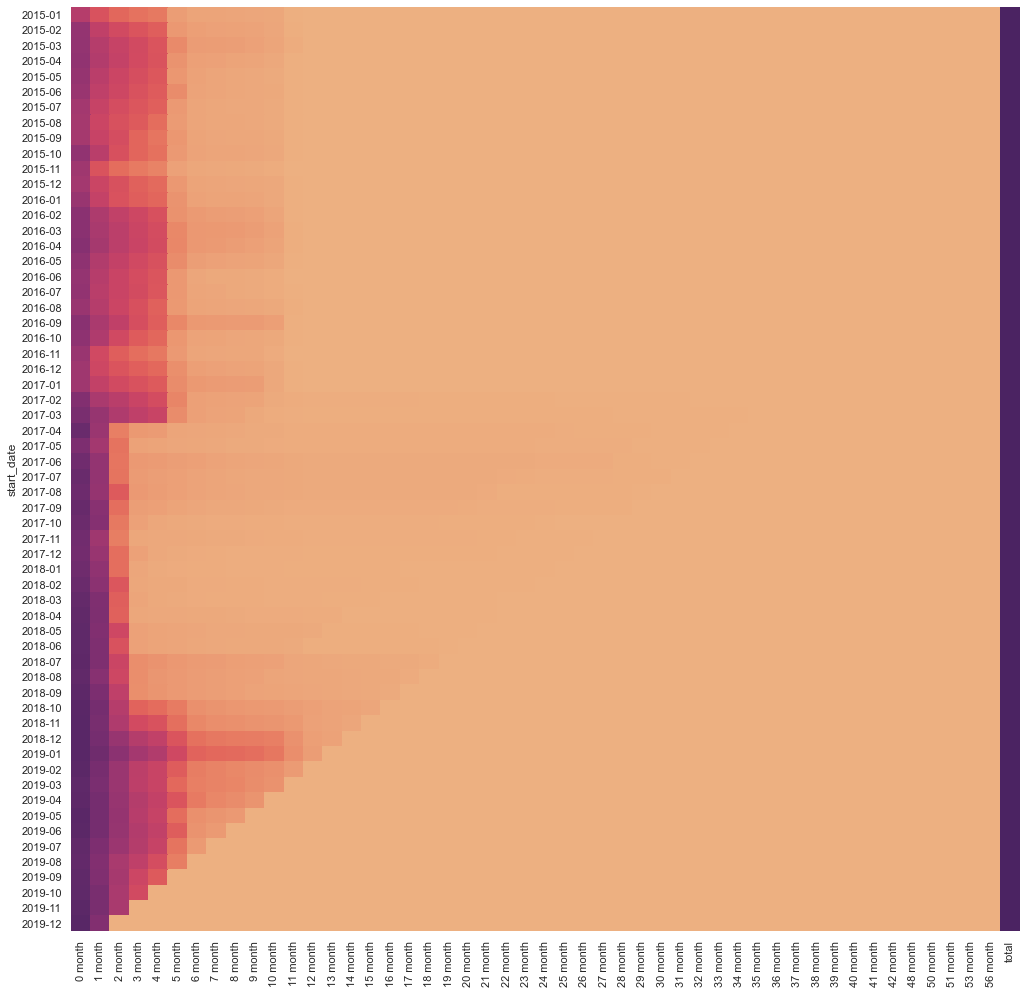

In [96]:
#Percentage
fig, ax = plt.subplots(figsize=(17,17))
cohort_size=cohorts_retention['total']
retention_month=round(cohorts_retention.divide(cohort_size, axis=0),6)
#heatmap:
# plt.figure(figsize=(30,20))
sns.heatmap(data=retention_month,
           cmap='flare',cbar=False)
col_name="total"
first_col =retention_month.pop(col_name)
retention_month.insert(0, col_name, first_col)

In [97]:
retention_month['retention_rate']=np.mean(retention_month, axis=1)

In [98]:
retention_month=retention_month.drop(['total', 'retention_rate'], axis=1)

In [99]:
a=np.mean(retention_month)

In [100]:
retention_month=retention_month.T

In [101]:
retention_month['r']=a

In [102]:
retention_month.head()

start_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,r
0 month,0.553473,0.692213,0.696401,0.706884,0.683988,0.671828,0.628697,0.619877,0.619196,0.703474,...,0.915584,0.930976,0.928737,0.905129,0.896853,0.907039,0.912300,0.926199,0.939385,0.800879
1 month,0.385840,0.509821,0.553407,0.565727,0.533204,0.513667,0.483480,0.458405,0.479433,0.537840,...,0.816739,0.822559,0.822711,0.785651,0.765935,0.776560,0.801932,0.802378,0.767385,0.655717
2 month,0.292578,0.428797,0.482580,0.490114,0.459045,0.449044,0.407541,0.390307,0.407292,0.393533,...,0.679654,0.683838,0.681344,0.661133,0.605395,0.614210,0.598662,0.604756,0.000000,0.443619
3 month,0.248698,0.372852,0.426685,0.423288,0.404087,0.386001,0.359845,0.344294,0.300561,0.300482,...,0.554834,0.543771,0.565469,0.557071,0.512298,0.456175,0.428465,0.000000,0.000000,0.301413
4 month,0.219694,0.331638,0.374617,0.376419,0.358816,0.341128,0.323874,0.265644,0.235120,0.251978,...,0.494228,0.483838,0.500869,0.480581,0.408887,0.347278,0.000000,0.000000,0.000000,0.255640


<AxesSubplot:title={'center':'Monthly Retention Rate'}>

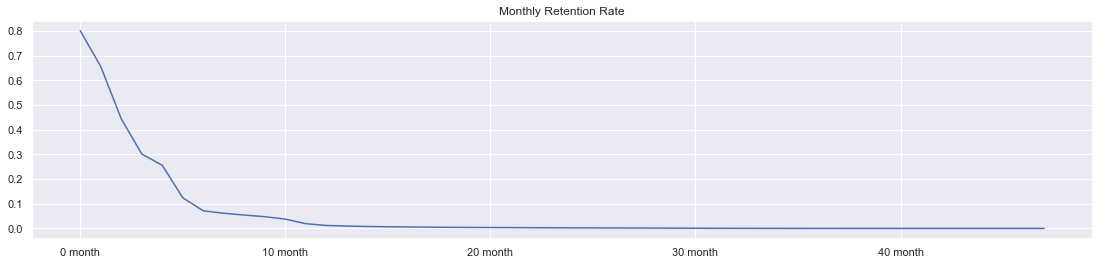

In [103]:
fig, ax = plt.subplots(figsize=(19,4))
plt.title('Monthly Retention Rate')
retention_month['r'].plot()

In [104]:
retention_month.head()

start_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,r
0 month,0.553473,0.692213,0.696401,0.706884,0.683988,0.671828,0.628697,0.619877,0.619196,0.703474,...,0.915584,0.930976,0.928737,0.905129,0.896853,0.907039,0.912300,0.926199,0.939385,0.800879
1 month,0.385840,0.509821,0.553407,0.565727,0.533204,0.513667,0.483480,0.458405,0.479433,0.537840,...,0.816739,0.822559,0.822711,0.785651,0.765935,0.776560,0.801932,0.802378,0.767385,0.655717
2 month,0.292578,0.428797,0.482580,0.490114,0.459045,0.449044,0.407541,0.390307,0.407292,0.393533,...,0.679654,0.683838,0.681344,0.661133,0.605395,0.614210,0.598662,0.604756,0.000000,0.443619
3 month,0.248698,0.372852,0.426685,0.423288,0.404087,0.386001,0.359845,0.344294,0.300561,0.300482,...,0.554834,0.543771,0.565469,0.557071,0.512298,0.456175,0.428465,0.000000,0.000000,0.301413
4 month,0.219694,0.331638,0.374617,0.376419,0.358816,0.341128,0.323874,0.265644,0.235120,0.251978,...,0.494228,0.483838,0.500869,0.480581,0.408887,0.347278,0.000000,0.000000,0.000000,0.255640


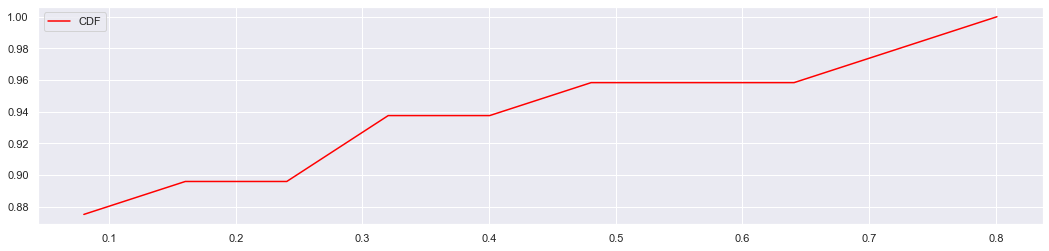

In [105]:
res=retention_month['r'].dropna()
res=res.to_frame().reset_index(drop=True)
import matplotlib.pyplot as plt 
import numpy as np 
count, bins_count = np.histogram(res, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, color='red',label="CDF")
plt.legend()

In [106]:
# mon=r.iloc[:,:20]
# mon=mon.T
# mon1=mon.iloc[:,:12]
# mon2=mon.iloc[:,12:24]
# mon3=mon.iloc[:,24:36]
# mon4=mon.iloc[:,36:48]
# mon5=mon.iloc[:,48:60]
# mrr=mrr.T
# sns.set_palette("rainbow_r",3)
# # fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,24),dpi=80)
# mrr.plot(linewidth=1, color=color,title='retention rate',legend=None)
# # sns.set_palette("rainbow_r",3)

# # fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(20,24),dpi=80)

# # mon1.plot(linewidth=1, color=color,ax=ax[0],title='retention rate in 2015 cohorts')
# # mon2.plot(linewidth=1, color=color, ax=ax[1], title='retention rate in 2016 cohorts')
# # mon3.plot(linewidth=1, color=color, ax=ax[2],title='retention rate in 2017 cohorts')
# # mon4.plot(linewidth=1, color=color, ax=ax[3],title='retention rate in 2018 cohorts')
# # mon5.plot( linewidth=1, color=color, ax=ax[4],title='retention rate in 2019 cohorts')

# # plt.xlabel('Months')
# # plt.subplots_adjust() 
# # plt.legend()
# ### average:
# import matplotlib.pyplot as plt 
# import numpy as np 
# count, bins_count = np.histogram(res, bins=10)
# # finding the PDF of the histogram using count values
# pdf = count / sum(count)
# # using numpy np.cumsum to calculate the CDF
# # We can also find using the PDF values by looping and adding
# cdf = np.cumsum(pdf)
# # plotting PDF and CDF
# plt.plot(bins_count[1:], cdf, color='red',label="CDF")
# plt.legend()
# fig, ax = plt.subplots(figsize=(19,4),dpi=80)
# plt.title('Average Monthly Retention Rate')
# sns.ecdfplot(data=res, x='retention_rate')
# retention_month['retention_rate']=np.mean(retention_month, axis=1)
# fig, ax = plt.subplots(figsize=(19,4))
# plt.title('Monthly Retention Rate')
# retention_month['retention_rate'].plot()
# res=retention_month['retention_rate']
# res=retention_month['retention_rate']
# res=res.to_frame().reset_index(drop=True)
# fig, ax = plt.subplots(figsize=(19,4),dpi=80)
# plt.title('Average Monthly Retention Rate')
# sns.ecdfplot(data=res, x='retention_rate')

#### build retention rate 

In [107]:
data=r

In [108]:
data=data.drop('r', axis=1)
data.head()

start_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
1 month,0.697124,0.736509,0.794667,0.800311,0.779552,0.764581,0.769019,0.739509,0.774283,0.764548,...,0.873646,0.892041,0.883544,0.885839,0.867999,0.854025,0.856149,0.879022,0.866313,0.816901
2 month,0.758288,0.841073,0.872017,0.866343,0.860918,0.874193,0.842932,0.851445,0.849529,0.731692,...,0.834711,0.832155,0.831355,0.828169,0.841509,0.790401,0.790936,0.746525,0.753705,0.000000
3 month,0.850025,0.869530,0.884173,0.863653,0.880276,0.859606,0.882968,0.882113,0.737950,0.763549,...,0.785329,0.816348,0.795175,0.829932,0.842601,0.846221,0.742703,0.715705,0.000000,NaN
4 month,0.883373,0.889464,0.877972,0.889273,0.887969,0.883749,0.900037,0.771561,0.782271,0.838580,...,0.900860,0.890767,0.889783,0.885758,0.862693,0.798141,0.761281,0.000000,NaN,NaN
5 month,0.355450,0.300370,0.410322,0.313716,0.285714,0.432608,0.280132,0.314088,0.443340,0.364505,...,0.611959,0.754745,0.553932,0.669173,0.502159,0.489004,0.000000,NaN,NaN,NaN


In [113]:
data=data.T.reset_index()
data['start_date']=data['start_date'].astype(str)

In [116]:
data.index=data.start_date
data=data.drop('start_date', axis=1)

In [119]:
data=data.T

In [121]:
data.head()

start_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
1 month,0.697124,0.736509,0.794667,0.800311,0.779552,0.764581,0.769019,0.739509,0.774283,0.764548,...,0.873646,0.892041,0.883544,0.885839,0.867999,0.854025,0.856149,0.879022,0.866313,0.816901
2 month,0.758288,0.841073,0.872017,0.866343,0.860918,0.874193,0.842932,0.851445,0.849529,0.731692,...,0.834711,0.832155,0.831355,0.828169,0.841509,0.790401,0.790936,0.746525,0.753705,0.000000
3 month,0.850025,0.869530,0.884173,0.863653,0.880276,0.859606,0.882968,0.882113,0.737950,0.763549,...,0.785329,0.816348,0.795175,0.829932,0.842601,0.846221,0.742703,0.715705,0.000000,NaN
4 month,0.883373,0.889464,0.877972,0.889273,0.887969,0.883749,0.900037,0.771561,0.782271,0.838580,...,0.900860,0.890767,0.889783,0.885758,0.862693,0.798141,0.761281,0.000000,NaN,NaN
5 month,0.355450,0.300370,0.410322,0.313716,0.285714,0.432608,0.280132,0.314088,0.443340,0.364505,...,0.611959,0.754745,0.553932,0.669173,0.502159,0.489004,0.000000,NaN,NaN,NaN


In [122]:
data.loc['1 month']['2015-01']

0.6971244289169578

In [125]:
df['start_date']=df['start_date'].astype(str)

In [135]:
df=df[df['duration_mon']!=0].reset_index(drop=True)

In [136]:
df.shape

(232957, 15)

In [137]:
res=[]
cohort=[]
duration=[]
for i in range(len(df)):
    cohort=df['start_date'][i]
    duration=df['duration_mon'][i]
    res.append(data.loc[str(duration)+' month'][cohort])

In [139]:
df['retention_rate']=res

## 1. Are there any factors that impact the length of member Lifetime? 
- Cohort-level
- Dependent variable: Length of memeber lifetime
- Factors: Importance feature selection:
    - 1. Corrletion
    - 2. RFE Cross-validation
    - 3. Multiple Linear Regression
    - 4. Random Forest

Based on monthly cohort, every cohort has a average retention rate. Based on retention rate, we can calculate average length of memeber lifetime based on cohort.

# Feature importance ranking
#### 1. Correlation metrics

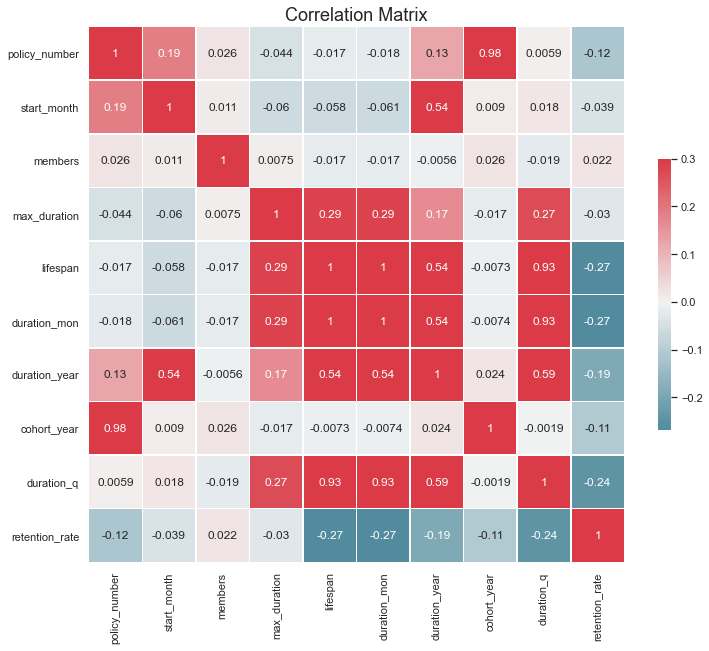

In [262]:
corr1=df.corr()
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
heatmap1=sns.heatmap(corr1,  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### 2.RFE Cross-validation

In [274]:
df.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q,duration_mon,duration_year,cohort_year,duration_q,retention_rate
0,86234540,2015-01,1,2015-02,1,180,CA,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
1,87090695,2015-01,1,2015-02,4,180,UT,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
2,87025320,2015-01,1,2015-02,1,180,CA,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
3,85396955,2015-01,1,2015-02,1,180,VA,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
4,86423740,2015-01,1,2015-02,1,180,TX,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124


In [266]:
# prepare data:
model=df[['start_month', 'members',
       'max_duration', 'state', 'carrier_name', 'lifespan', 
        'duration_mon', 'retention_rate']]

In [263]:
model=pd.get_dummies(model)
X=model.drop('lifespan',axis=1)
y=model['lifespan']

In [264]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Normalization:
scaler = StandardScaler()
X_train=scaler.fit_transform(X)

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.svm import SVR
# estimator = SVR()
# selector = RFECV(step=20,estimator=estimator)
# selector = selector.fit(X, y)
# # df3=pd.DataFrame()
# # df3['rank']=selector.ranking_

In [ ]:
# feature_imp = pd.Series(selector.ranking_,index=X.columns).sort_values()
# feature_imp
# # Creating a bar plot
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")

### 3. Multiple Linear Regression

In [145]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LinearRegression()
modelCV.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [146]:
feature_positive = pd.Series(modelCV.coef_,index=X .columns).sort_values(ascending=False)
feature_positive[:10]

duration_mon              30.438045
carrier_name_CARRIER8      0.357222
carrier_name_CARRIER11     0.334148
state_WA                   0.248265
carrier_name_CARRIER6      0.164952
state_AK                   0.133010
carrier_name_CARRIER10     0.131073
state_CA                   0.096970
carrier_name_CARRIER1      0.074452
start_month                0.073829
dtype: float64

In [147]:
feature_negative = pd.Series(modelCV.coef_,index=X .columns).sort_values()
feature_negative[:10]

retention_rate           -0.616079
carrier_name_CARRIER13   -0.319147
carrier_name_CARRIER14   -0.298523
carrier_name_CARRIER7    -0.270316
carrier_name_CARRIER9    -0.217116
state_RI                 -0.175016
state_CT                 -0.081348
state_NM                 -0.076636
state_SD                 -0.059666
state_OK                 -0.058775
dtype: float64

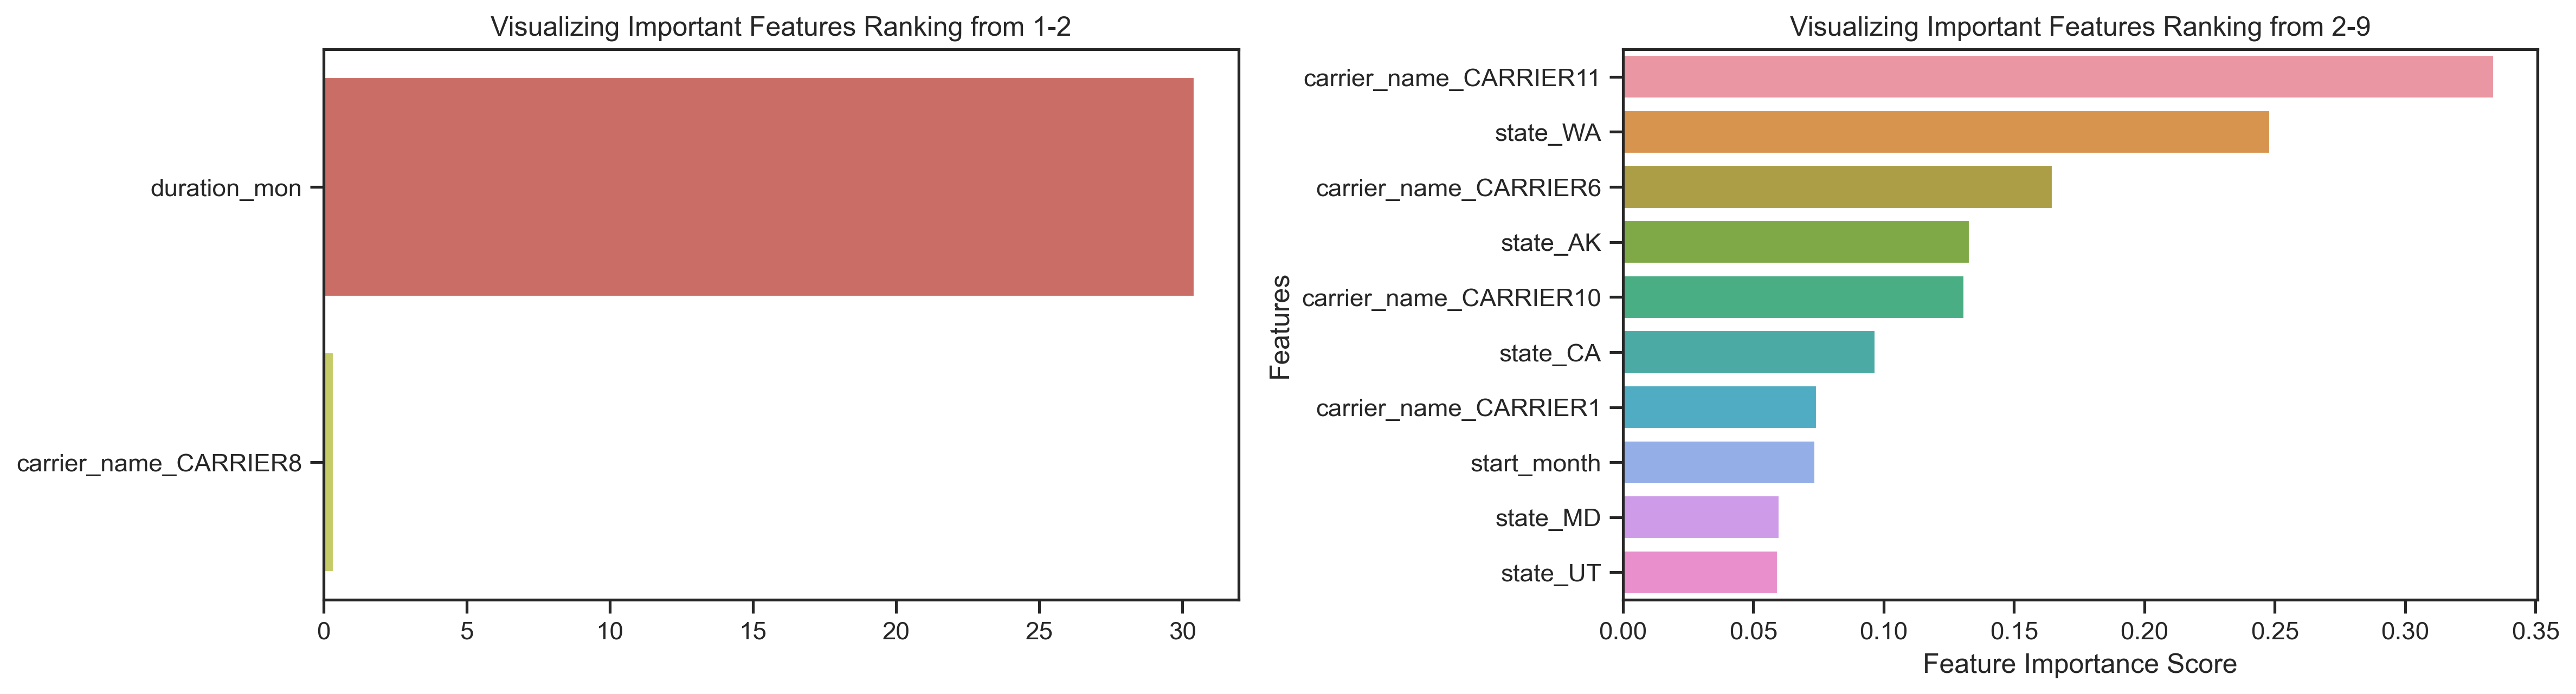

In [257]:
# Creating a bar plot
plt.figure(figsize=(16,8),dpi=300)
plt.ticklabel_format(useOffset=False)
plt.subplot(2,2,1)
plt.title("Visualizing Important Features Ranking from 1-2")
sns.barplot(x=feature_positive[0:2], y=feature_positive.index[0:2])
plt.subplot(2,2,2)
plt.title("Visualizing Important Features Ranking from 2-9")
sns.barplot(x=feature_positive[2:12], y=feature_positive.index[2:12])
# plt.subplot(2,2,3)
# plt.title("Visualizing Important Features Ranking from 1-2")
# sns.barplot(x=feature_negative[0:2], y=feature_negative.index[0:2])
# plt.subplot(2,2,4)
# sns.barplot(x=feature_negative[2:10], y=feature_negative.index[2:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features Ranking from 2-9")
plt.tight_layout()

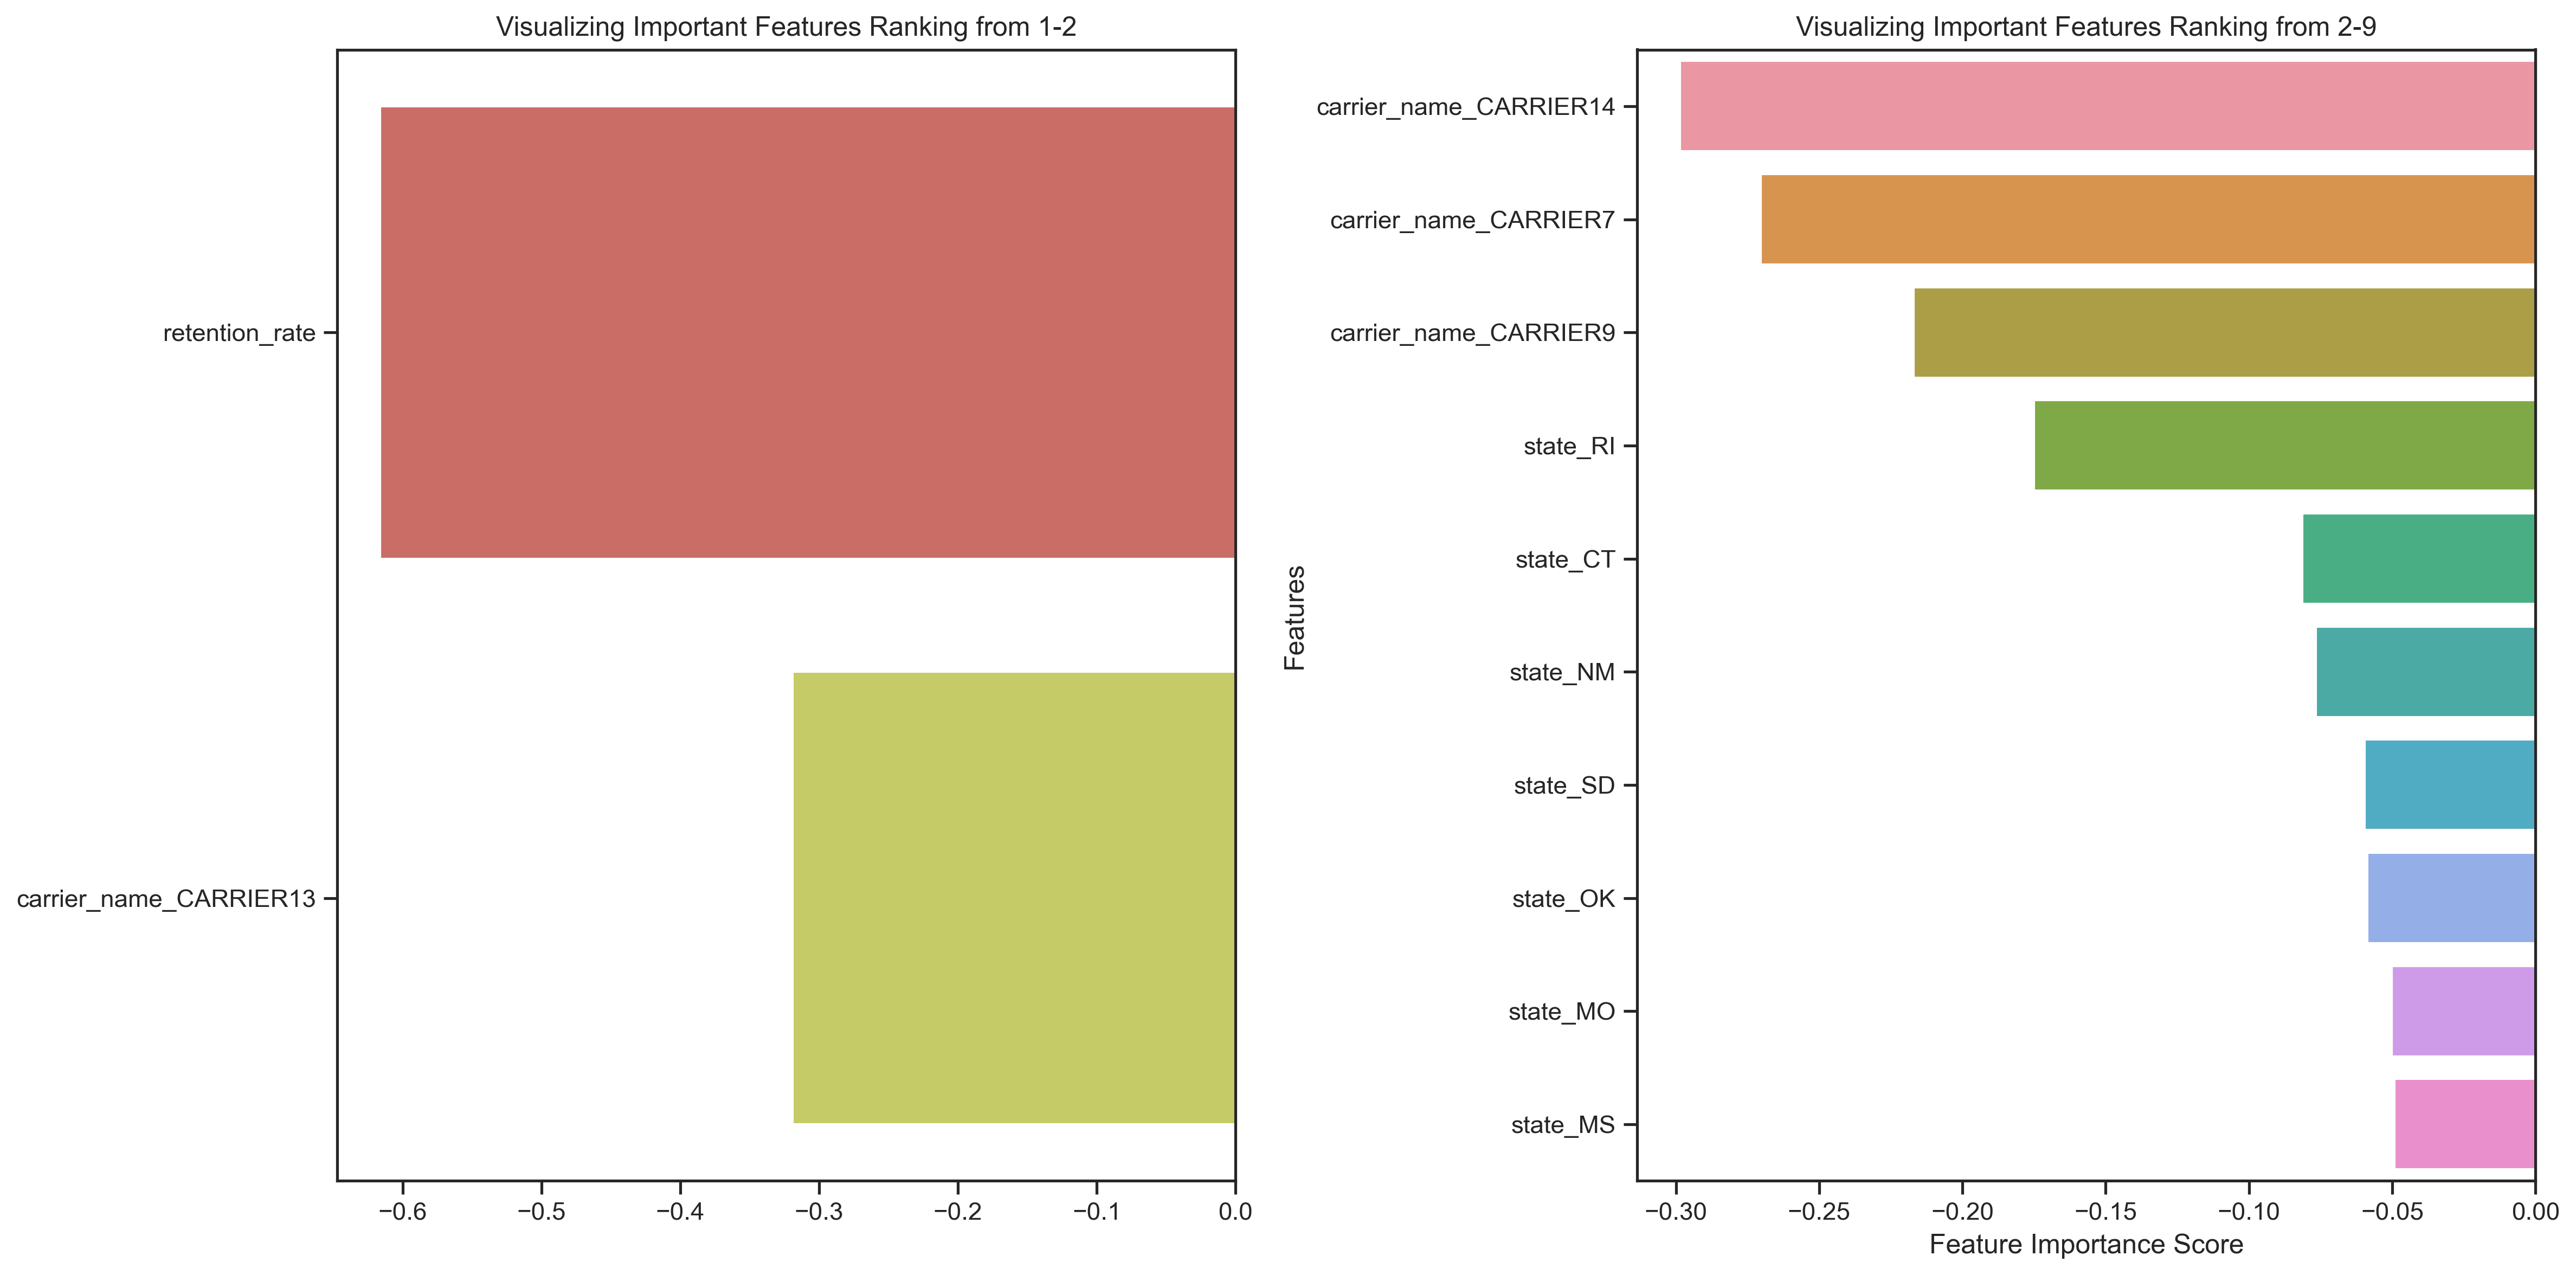

In [258]:
# Creating a bar plot
plt.figure(figsize=(16,8),dpi=300)
plt.ticklabel_format(useOffset=False)
plt.subplot(1,2,1)
plt.title("Visualizing Important Features Ranking from 1-2")
sns.barplot(x=feature_negative[0:2], y=feature_negative.index[0:2])
plt.subplot(1,2,2)
sns.barplot(x=feature_negative[2:12], y=feature_negative.index[2:12])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features Ranking from 2-9")
plt.tight_layout()

### 4. Random Forest

In [278]:
size=df.groupby('start_date').size()
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)
for i in size:
    regressor.fit(X, y)
    feature_imp = pd.Series(regressor.feature_importances_,index=X.columns).sort_values(ascending=False)
    feature_imp[:10]
    X_train[:size[0]]

232957

In [279]:
X_train[:size[0]]

array([[-1.60881019, -0.47907013, -0.03343391, ..., -0.13563078,
        -0.10911558, -0.07702648],
       [-1.60881019,  2.52315566, -0.03343391, ..., -0.13563078,
        -0.10911558, -0.07702648],
       [-1.60881019, -0.47907013, -0.03343391, ..., -0.13563078,
        -0.10911558, -0.07702648],
       ...,
       [-1.60881019, -0.47907013,  1.78935637, ..., -0.13563078,
        -0.10911558, -0.07702648],
       [-1.60881019, -0.47907013, -0.03343391, ..., -0.13563078,
        -0.10911558, -0.07702648],
       [-1.60881019, -0.47907013, -0.03343391, ..., -0.13563078,
        -0.10911558, -0.07702648]])

In [ ]:
for i in :
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)
    regressor.fit(X, y)
    feature_imp = pd.Series(regressor.feature_importances_,index=X.columns).sort_values(ascending=False)
    feature_imp[:10]

In [259]:
from sklearn.ensemble import RandomForestRegressor
# use 10 trees for starter and just default setting to train the first ensembled tree
regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)
regressor.fit(X, y)
feature_imp = pd.Series(regressor.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp[:10]

duration_mon             9.998905e-01
start_month              8.675296e-05
carrier_name_CARRIER4    8.918177e-06
retention_rate           8.064223e-06
members                  4.001658e-06
state_MD                 6.539146e-07
carrier_name_CARRIER3    4.850569e-07
carrier_name_CARRIER1    1.939158e-07
max_duration             1.137325e-07
state_NE                 8.711857e-08
dtype: float64

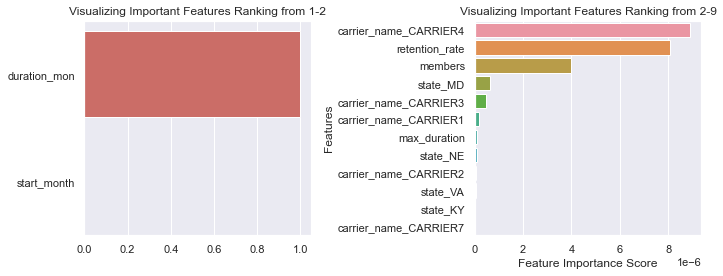

In [260]:
# Creating a bar plot
plt.figure(figsize=(10,4))
plt.ticklabel_format(useOffset=False)
sns.set_style("darkgrid")
plt.subplot(1,2,1)
plt.title("Visualizing Important Features Ranking from 1-2")
sns.barplot(x=feature_imp[0:2], y=feature_imp.index[0:2])
plt.subplot(1,2,2)
sns.barplot(x=feature_imp[2:14], y=feature_imp.index[2:14])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features Ranking from 2-9")
plt.tight_layout()

## 2.What does Monthly Retention Curve look like? How about Cumulative Retention Curve? 

**Monthly Retention Rates across the cohort lifetime (MRR)**

-	Defined as: Retained members at month t/Retained members at month t-1 
-	This metric changes across the months in the cohort lifetime


### Normal method to calculate retention rate:

<AxesSubplot:title={'center':'Monthly Retention Rate'}>

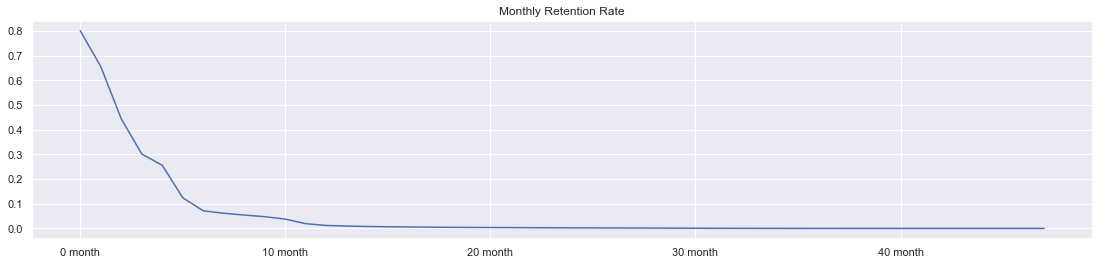

In [152]:
retention_month['retention_rate']=np.mean(retention_month, axis=1)
fig, ax = plt.subplots(figsize=(19,4))
plt.title('Monthly Retention Rate')
retention_month['retention_rate'].plot()

In [154]:
retention_month=retention_month.drop('r', axis=1)

In [160]:
retention_month=retention_month.drop('retention_rate', axis=1)

In [164]:
retention_month=retention_month.T

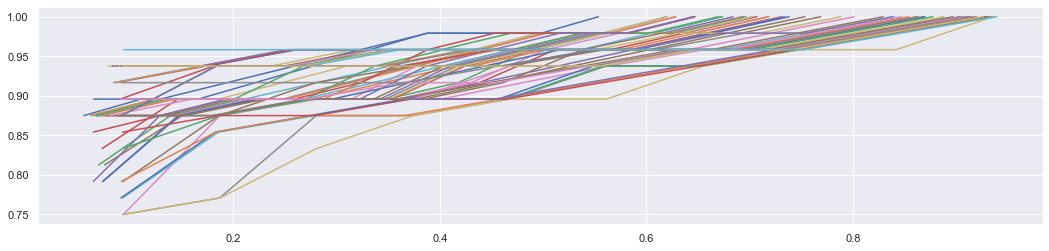

In [166]:
cols=retention_month.columns
for i in cols:   
    count, bins_count = np.histogram(retention_month[i].dropna(), bins=10)
    cdf = np.cumsum(count / sum(count))
    plt.plot(bins_count[1:], cdf)

### Monthly Retention Curve 

In [173]:
r.head()

start_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,r
1 month,0.697124,0.736509,0.794667,0.800311,0.779552,0.764581,0.769019,0.739509,0.774283,0.764548,...,0.892041,0.883544,0.885839,0.867999,0.854025,0.856149,0.879022,0.866313,0.816901,0.811630
2 month,0.758288,0.841073,0.872017,0.866343,0.860918,0.874193,0.842932,0.851445,0.849529,0.731692,...,0.832155,0.831355,0.828169,0.841509,0.790401,0.790936,0.746525,0.753705,0.000000,0.691083
3 month,0.850025,0.869530,0.884173,0.863653,0.880276,0.859606,0.882968,0.882113,0.737950,0.763549,...,0.816348,0.795175,0.829932,0.842601,0.846221,0.742703,0.715705,0.000000,NaN,0.635702
4 month,0.883373,0.889464,0.877972,0.889273,0.887969,0.883749,0.900037,0.771561,0.782271,0.838580,...,0.890767,0.889783,0.885758,0.862693,0.798141,0.761281,0.000000,NaN,NaN,0.833802
5 month,0.355450,0.300370,0.410322,0.313716,0.285714,0.432608,0.280132,0.314088,0.443340,0.364505,...,0.754745,0.553932,0.669173,0.502159,0.489004,0.000000,NaN,NaN,NaN,0.565646


In [261]:
# mrr=r.drop(columns={'r'})
# sns.set_palette("rainbow_r",3)
# # fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,24),dpi=80)
# mrr.plot(linewidth=1, title='retention rate',legend=None)
# plt.tight_layout()

### Retention rate of each cohort group details based on different year 

In [ ]:
# mon=retention_month.iloc[:,:20]
# mon=mon.T
# mon1=mon.iloc[:,:12]
# mon2=mon.iloc[:,12:24]
# mon3=mon.iloc[:,24:36]
# mon4=mon.iloc[:,36:48]
# mon5=mon.iloc[:,48:62]
# color=['teal', 'maroon', 'blue', 'brown', 'cyan', 'yellow', 'orange', 'purple', 'red', 'green', 'magenta']
# # sns.set_palette("rainbow_r",3)

# fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(20,20),dpi=80)

# mon1.plot(linewidth=1, color=color,ax=ax[0])
# plt.title('Retention Rate in 2015')

# mon2.plot(linewidth=1, color=color, ax=ax[1])
# plt.title('Retention Rate in 2016')

# mon3.plot(linewidth=1, color=color, ax=ax[2])
# plt.title('Retention Rate in 2017')

# mon4.plot(linewidth=1, color=color, ax=ax[3])
# plt.title('Retention Rate in 2018')

# mon5.plot( linewidth=1, color=color, ax=ax[4])
# plt.title('Retention Rate in 2019')
# plt.xlabel('Months')
# plt.subplots_adjust() 
# plt.legend()

#### Average Monthly Retention Rate Cummlative Distribution

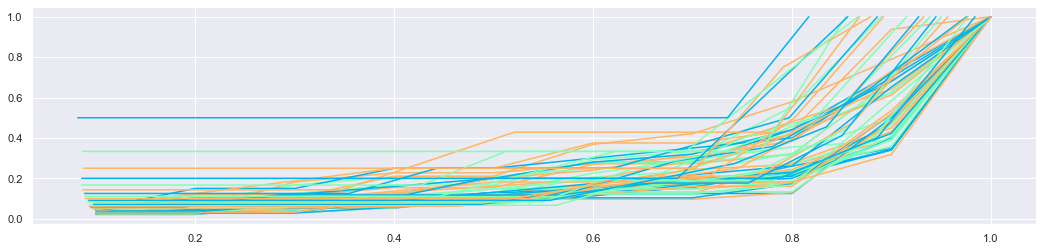

In [176]:
cols=mrr.columns
for i in cols:   
    count, bins_count = np.histogram(mrr[i].dropna(), bins=10)
    cdf = np.cumsum(count / sum(count))
    plt.plot(bins_count[1:], cdf,label=str(i))

## 3.(1) 3.	What would be your statistical approach to predict Cumulative Retention Curve for 2019 cohorts using previous years’ data? 

In [178]:
df_train=df[df['start_date']<'2019-01']
df_test=df[df['start_date']>='2019-01']

In [179]:
df_train.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q,duration_mon,duration_year,cohort_year,duration_q,retention_rate
0,86234540,2015-01,1,2015-02,1,180,CA,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
1,87090695,2015-01,1,2015-02,4,180,UT,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
2,87025320,2015-01,1,2015-02,1,180,CA,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
3,85396955,2015-01,1,2015-02,1,180,VA,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124
4,86423740,2015-01,1,2015-02,1,180,TX,CARRIER1,32,2015Q1,2015Q1,1,1,2015,0,0.697124


In [180]:
df_train.shape[0]

196406

In [181]:
df_train=df[df['start_date']<'2019-01']
df_test=df[df['start_date']>='2019-01']
n_train=df_train.shape[0]
n_test=df_test.shape[0]
df_model=df[[ 'start_month', 'members',
       'max_duration', 'state', 'carrier_name', 'lifespan', 
        'duration_mon', 'duration_year', 'cohort_year',
       'duration_q', 'retention_rate']]

In [182]:
df_model=pd.get_dummies(df_model)

In [183]:
df_model.shape

(232957, 70)

In [184]:
n_test

36551

In [185]:
df_train=df_model[:n_train]
df_test=df_model[n_train:]

In [186]:
X_train=df_train.drop(columns={'retention_rate'})
y_train=df_train['retention_rate']

X_test=df_test.drop(columns={'retention_rate'})
y_test=df_test['retention_rate']

In [187]:
# Normalization:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [188]:
X_train.shape,y_train.shape

((196406, 69), (196406,))

In [189]:
X_test.shape

(36551, 69)

In [190]:
# scikit Linear Regression by default uses L2 regularization
from sklearn.linear_model import LinearRegression
lin_reg_sklearn = LinearRegression(fit_intercept = True, normalize = False)
lin_reg_sklearn.fit(X_train, y_train)
y_pred_lin= lin_reg_sklearn.predict(X_test)
evaluation(y_test, y_pred_lin)

root mean square error:  33818578474.95
mean square error:  1.1436962500665921e+21
explained_variance_score:  -9.48710548263994e+21
max_error:  1140445093728.87
mean_absolute_error:  24326227061.12
median_absolute_error:  15627647552.56


## XGBT

In [191]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [192]:
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [193]:
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.997280450909895


In [194]:
ypred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 0.16
RMSE: 0.40


In [195]:
evaluation(y_test, ypred)

root mean square error:  0.4
mean square error:  0.16
explained_variance_score:  -0.22
max_error:  1.05
mean_absolute_error:  0.29
median_absolute_error:  0.23


## 3.(2) How is it validated against the actual curve observed? 

In [203]:
df_train=df[df['start_date']<'2019-01']
df_test=df[df['start_date']>='2019-01']

In [204]:
test=df_test[['start_date','duration_mon','retention_rate']]
test['ypred']=ypred

In [205]:
test.head()

,start_date,duration_mon,retention_rate,ypred
196406,2019-01,1,0.905347,0.794586
196407,2019-01,1,0.905347,0.794586
196408,2019-01,1,0.905347,0.794586
196409,2019-01,1,0.905347,0.789948
196410,2019-01,1,0.905347,0.794586


In [207]:
real=test.groupby(['start_date', 'duration_mon'])['retention_rate'].first().to_frame().reset_index()

In [211]:
ypred=test.groupby(['start_date', 'duration_mon'])['ypred'].mean().to_frame().reset_index()

In [210]:
real_plot=pd.pivot_table(real, values = 'retention_rate',index = 'duration_mon', columns= 'start_date')

In [213]:
ypred_plot=pd.pivot_table(ypred, values = 'ypred',index = 'duration_mon', columns= 'start_date')

## Predictive Cumulative Retention Curve for 2019

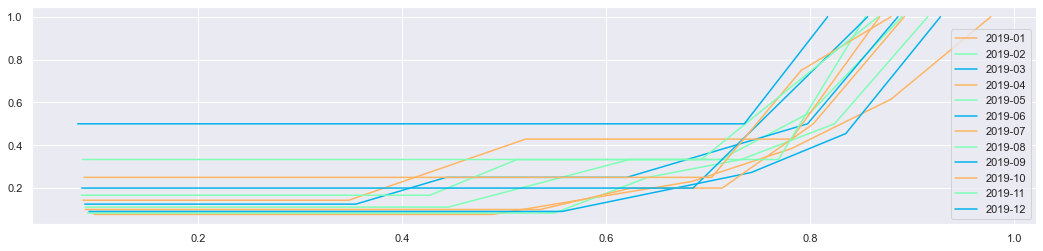

In [216]:
cols=real_plot.columns
for i in cols:   
    count, bins_count = np.histogram(real_plot[i].dropna(), bins=10)
    cdf = np.cumsum(count / sum(count))
    plt.plot(bins_count[1:], cdf,label=str(i))
    plt.legend()

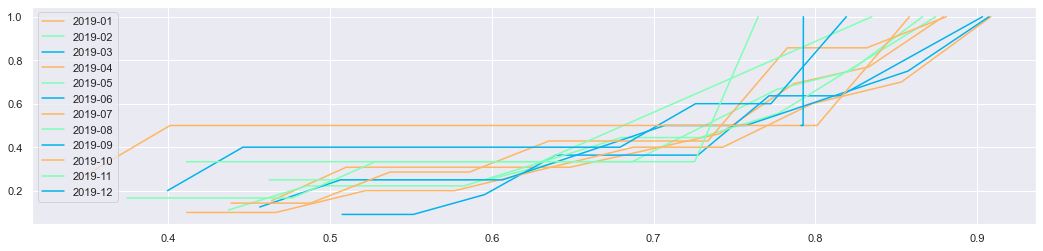

In [217]:
cols=ypred_plot.columns
for i in cols:   
    count, bins_count = np.histogram(ypred_plot[i].dropna(), bins=10)
    cdf = np.cumsum(count / sum(count))
    plt.plot(bins_count[1:], cdf,label=str(i))
    plt.legend()

In [ ]:
real=test['retention_rate'].to_frame()
ypred=test['ypred'].to_frame()

In [ ]:
real=real.drop_duplicates()


In [ ]:
ypred=ypred.drop_duplicates()

In [ ]:
ypred=ypred.groupby('start_date')['ypred'].mean().to_frame()

In [ ]:
ypred.plot(kind='bar')

In [ ]:
fig, ax = plt.subplots(figsize=(19,4),dpi=80)
plt.title('Average Monthly Retention Rate')
sns.ecdfplot(data=real, x='retention_rate')
sns.ecdfplot(data=ypred, x='ypred')

In [228]:
a=np.mean(real_plot, axis=1)
real_plot['r']=a
b=np.mean(real_plot, axis=1)
ypred_plot['r']=b

In [247]:
sns.set_style('ticks')

In [250]:
sns.set_palette("hls")

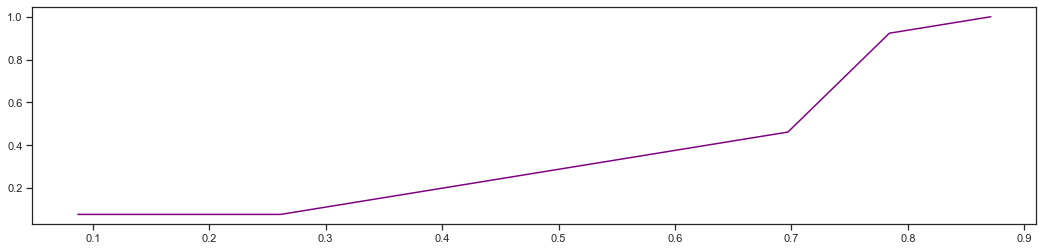

In [254]:
count, bins_count = np.histogram(real_plot['r'], bins=10)
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
# plotting PDF and CDF
plt.plot(bins_count[1:], cdf, label="real_CDF",color='purple')

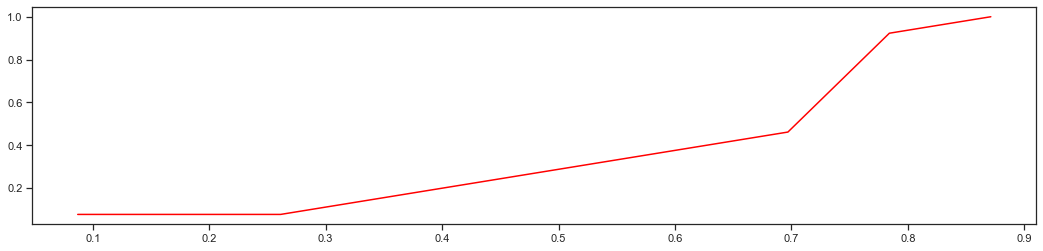

In [255]:
count, bins_count = np.histogram(ypred_plot['r'], bins=10)
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
# plotting PDF and CDF
plt.plot(bins_count[1:], cdf, label="real_CDF",color='red')